# Evaluation of trained baselines models on test data
Please, check if you downloaded and inserted pickled, trained models in the `models` directory.  
To download pretrained models refer to `README.md` file.  
Then simply run following cells :) 

## Loading Data

In [1]:
import anndata
import pandas as pd
import numpy as np
import pickle

TEST_ANNDATA_PATH = "./data/test/cell_data.h5ad"

In [2]:
test_anndata = anndata.read_h5ad(TEST_ANNDATA_PATH)
labels = list(test_anndata.obs.iloc[:, -1])
markers_names = list(test_anndata.var["marker"])
exprs_matrix = test_anndata.layers["exprs"]

In [3]:
# Creating expression DataFrame
df = pd.DataFrame(exprs_matrix)
df.columns = markers_names

# Adding labels column
df["label"] = labels

In [4]:
df.head()

,MPO,HistoneH3,SMA,CD16,CD38,HLADR,CD27,CD15,CD45RA,CD163,...,CD40,CD4,CD14,Ecad,CD303,CD206,cleavedPARP,DNA1,DNA2,label
0,0.037029,3.077803,0.835016,0.449914,0.452033,1.183225,0.343235,2.233427,0.630083,0.258038,...,0.588651,1.149224,1.683922,2.214463,0.119413,0.752071,0.163389,5.191388,5.840837,Tumor
1,0.110884,2.386985,0.121685,0.152446,0.137752,0.434370,0.000000,2.359260,1.073211,0.310309,...,0.115367,0.852582,1.756712,1.158866,0.121370,0.381198,0.000000,4.569882,5.151850,Tumor
2,0.076847,2.214436,0.475846,0.733657,0.245479,1.605910,0.786704,2.297242,1.027829,0.730424,...,1.150302,0.985779,2.768580,2.312366,0.000000,0.743584,0.000000,3.991332,4.561579,Tumor
3,0.157799,3.100977,0.900064,0.404796,0.495087,0.826856,0.225954,1.317597,0.712317,0.212812,...,0.778417,1.518113,1.669911,1.711128,0.110411,0.534567,0.028101,5.317619,5.901243,Tumor
4,0.041655,2.453592,1.286608,0.300512,0.282942,1.202643,0.072611,0.747591,0.792039,0.160200,...,0.383454,1.257195,2.192203,1.212957,0.009474,0.334543,0.026420,4.510334,5.132832,Tumor


### Preparing X_test, y_test and data scalling

In [5]:
X_test = df[markers_names]
y_test = df["label"]

with open("./util/scaler.pkl", "rb") as file:
    scaler = pickle.load(file) 
    X_test_scaled = pd.DataFrame(scaler.transform(X_test))

# Models Evaluation

In [6]:
from evaluate_utils import evaluate

## Logistic Regression

In [12]:
%%capture
with open("./models/best_LR.pkl", "rb") as f:
    best_model = pickle.load(f)

evaluation_LR = evaluate(best_model, X_test_scaled, y_test)

#### Global metrics (`ACC`, `macro-F1`):

In [14]:
print(f"ACC on the test set: {evaluation_LR["ACC_glob"]}")
print(f"macro_F1 on the test set: {evaluation_LR["macro_F1"]}")

ACC on the test set: 0.924073465169806
macro_F1 on the test set: 0.8398763450686967


#### Confusion matrix

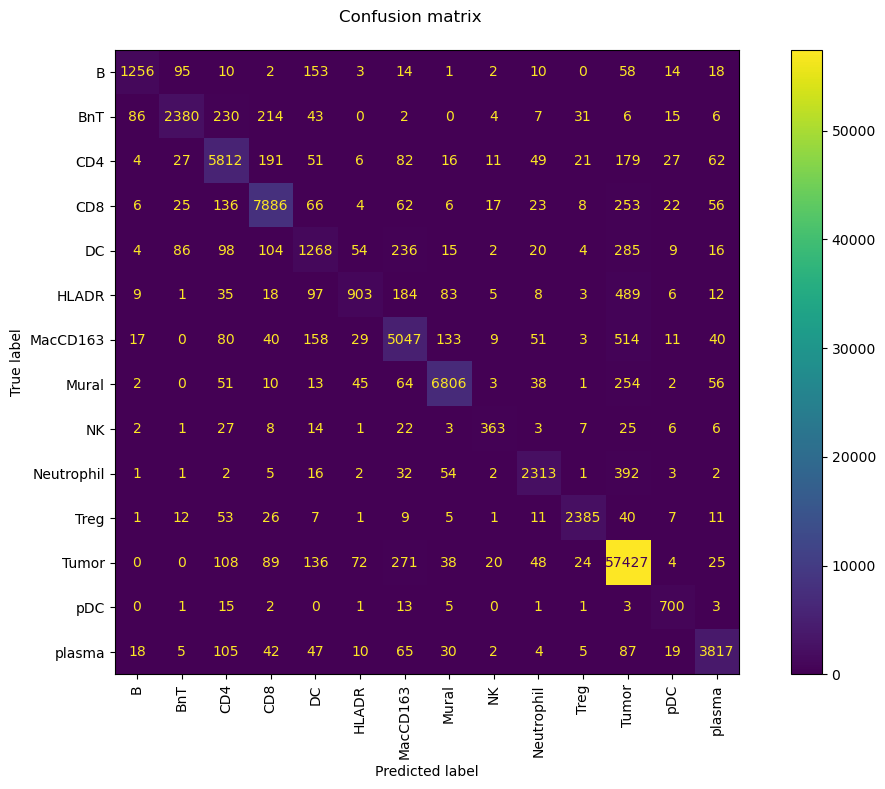

In [23]:
evaluation_LR["conf_plot"]

#### AUC, Average Precision Score (AP) and ACC across cell types

In [31]:
evaluation_LR["results_per_celltypes"]

,AUC,AP,ACC
B,0.997188,0.917825,0.767726
BnT,0.997686,0.932044,0.787037
CD4,0.994541,0.944562,0.888957
CD8,0.997320,0.970387,0.920187
DC,0.969581,0.586331,0.576102
HLADR,0.979833,0.677321,0.487318
MacCD163,0.991594,0.899605,0.823059
Mural,0.998093,0.981396,0.926617
NK,0.995539,0.833590,0.743852
Neutrophil,0.996335,0.923909,0.818471


## Random Forest

In [16]:
%%capture
with open("./models/best_RF.pkl", "rb") as f:
    best_model = pickle.load(f)

evaluation_RF = evaluate(best_model, X_test, y_test)

#### Global metrics (`ACC`, `macro-F1`):

In [17]:
print(f"ACC on the test set: {evaluation_RF["ACC_glob"]}")
print(f"macro_F1 on the test set: {evaluation_RF["macro_F1"]}")

ACC on the test set: 0.9386725539010756
macro_F1 on the test set: 0.8592776213690013


#### Confusion matrix

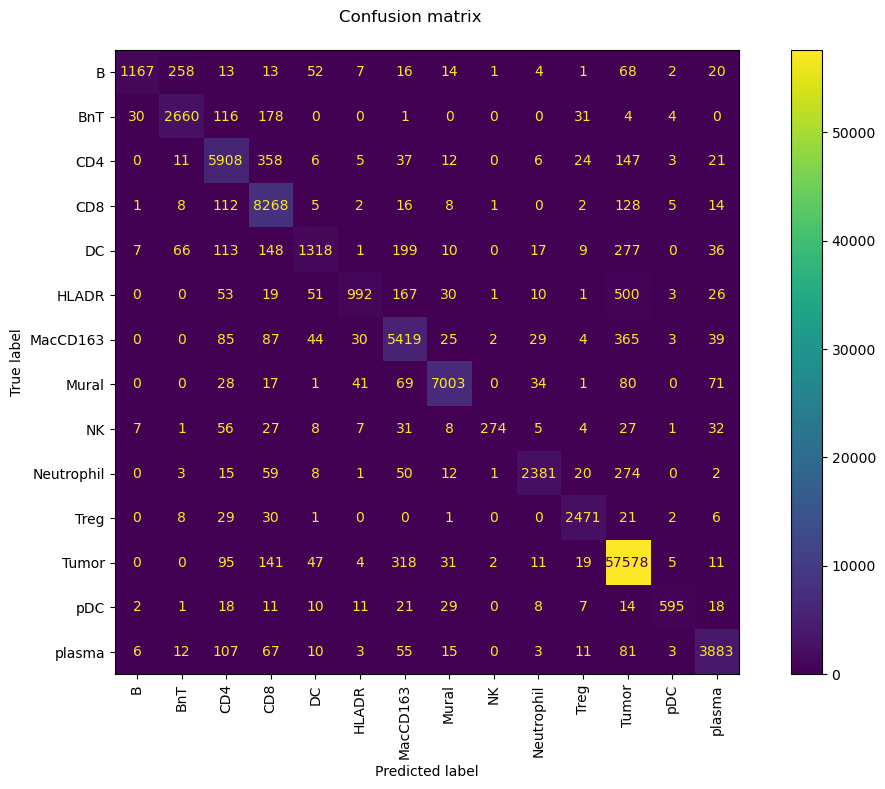

In [24]:
evaluation_RF["conf_plot"]

#### AUC, Average Precision Score (AP) and ACC across cell types

In [30]:
evaluation_RF["results_per_celltypes"]

,AUC,AP,ACC
B,0.997780,0.934508,0.713325
BnT,0.998422,0.956440,0.879630
CD4,0.995804,0.953438,0.903640
CD8,0.997870,0.976784,0.964761
DC,0.987813,0.785168,0.598819
HLADR,0.982267,0.768364,0.535348
MacCD163,0.995743,0.936037,0.883725
Mural,0.999211,0.992365,0.953438
NK,0.996179,0.823215,0.561475
Neutrophil,0.996848,0.958673,0.842534


## XGBoost

In [9]:
# I load also "fitted" to train data label encoder
with open("./util/label_encoder_XGB", "rb") as f:
    le = pickle.load(f)

In [19]:
%%capture
with open("./models/best_XGB.pkl", "rb") as f:
    best_model = pickle.load(f)

evaluation_XGB = evaluate(best_model, X_test, y_test, le)

#### Global metrics (`ACC`, `macro-F1`):

In [20]:
print(f"ACC on the test set: {evaluation_XGB["ACC_glob"]}")
print(f"macro_F1 on the test set: {evaluation_XGB["macro_F1"]}")

ACC on the test set: 0.9421203438395416
macro_F1 on the test set: 0.8726356566489981


#### Confusion matrix

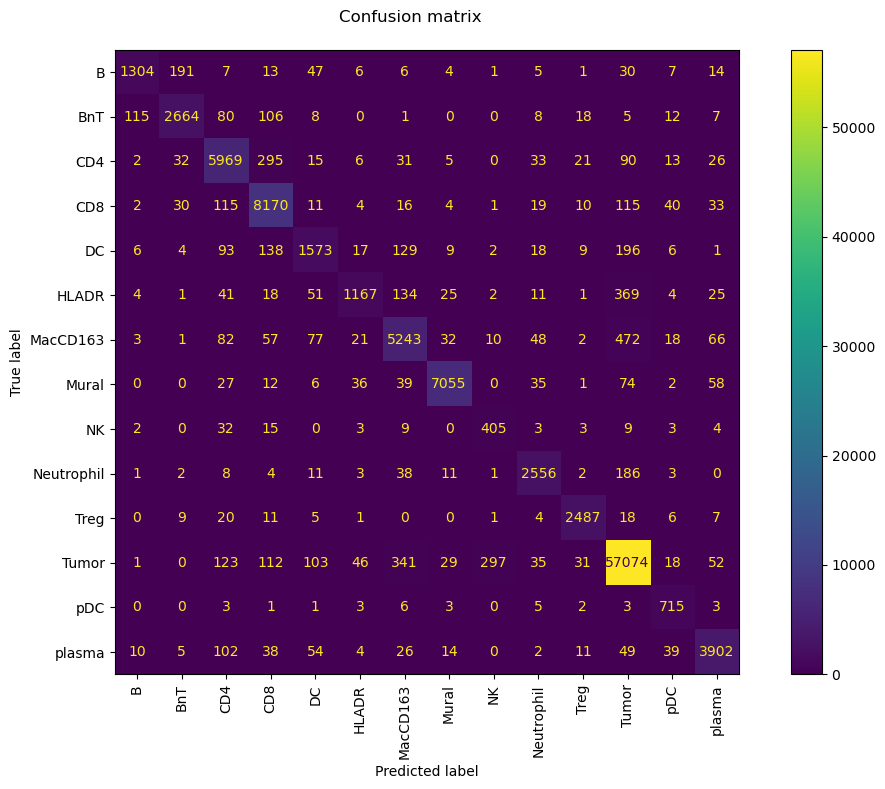

In [27]:
evaluation_XGB["conf_plot"]

#### AUC, Average Precision Score (AP) and ACC across cell types

In [28]:
evaluation_XGB["results_per_celltypes"]

,AUC,AP,ACC
B,0.997612,0.928296,0.797066
BnT,0.998662,0.960826,0.880952
CD4,0.996522,0.963632,0.912970
CD8,0.998158,0.978863,0.953326
DC,0.993395,0.839772,0.714675
HLADR,0.983688,0.792099,0.629790
MacCD163,0.996464,0.949865,0.855023
Mural,0.998994,0.992885,0.960517
NK,0.996511,0.837649,0.829918
Neutrophil,0.998636,0.971319,0.904459
